In [1]:
import csv
import math
import json
import os
import cv2

from PIL import Image, ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, Flatten, Dropout, Dense, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import Adam

D:\Programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Preprocessing ###
Building up our training set, validation set and images from Pascal 2007 dataset.

In [2]:
path = os.getcwd()
dataset_path = os.path.join(os.getcwd(), "dataset/Annotations")
image_path = os.path.join(os.getcwd(), "dataset/JPEGImages")

train_path = os.path.join(dataset_path, "pascal_train2007.json")
val_path = os.path.join(dataset_path, "pascal_val2007.json")

# building up training dataset
with open(train_path) as f:
    train_data = json.load(f)

train_dataset = []
for image in train_data["images"]:
    image_set = {}
    image_set["image"] = image
    
    anno_list = []
    for anno in train_data["annotations"]:
        if anno["image_id"] == image['id']:
            anno_list.append(anno)
    image_set["annotation"] = sorted(anno_list, key=lambda x:x["area"], reverse=True)[0]
    train_dataset.append(image_set)


# building up validation dataset    
with open(val_path) as f:
    val_data = json.load(f)
    
val_dataset = []
for image in val_data["images"]:
    image_set = {}
    image_set["image"] = image
    
    anno_list = []
    for anno in val_data["annotations"]:
        if anno["image_id"] == image["id"]:
            anno_list.append(anno)
    image_set["annotation"] = sorted(anno_list, key=lambda x:x["area"], reverse=True)[0]
    val_dataset.append(image_set)

# redistribute list
combine_list = train_dataset + val_dataset
train_dataset = combine_list[:int(len(combine_list) * 0.8)]
val_dataset = combine_list[int(len(combine_list) * 0.8):]
    
# converter to convert id to label name
id_to_name = {c['id']:c['name'] for c in train_data['categories']}

print(train_data.keys())
print()
print("images: {}\n".format(train_data['images'][0]))
print("annotations: {}\n".format(train_data['annotations'][0]))
print("categories: {}\n".format(train_data['categories'][0]))

dict_keys(['annotations', 'images', 'categories', 'type'])

images: {'file_name': '000012.jpg', 'id': 12, 'height': 333, 'width': 500}

annotations: {'area': 34104, 'iscrowd': 0, 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'id': 1, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'ignore': 0, 'category_id': 7}

categories: {'name': 'aeroplane', 'supercategory': 'none', 'id': 1}



In [3]:
print("Combine dataset: {}".format(len(combine_list)))
print("Train dataset: {}".format(len(train_dataset)))
print("Validate dataset: {}".format(len(val_dataset)))

5011
4008
1003


### Data exploration ###
Exploring and resizing our images to see how they looks like

In [3]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def show_img(im, figsize=(10, 10), ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    return ax

def load_image(path):
    img = cv2.imread(path, 1) 
    return img[..., ::-1]

Change the number in *data = train_dataset[19]* to view different images.

{'annotation': {'area': 93903, 'iscrowd': 0, 'segmentation': [[108, 32, 108, 309, 447, 309, 447, 32]], 'id': 47, 'image_id': 83, 'bbox': [108, 32, 339, 277], 'ignore': 0, 'category_id': 7}, 'image': {'file_name': '000083.jpg', 'id': 83, 'height': 333, 'width': 500}}
[48, 21, 151, 186]
(224, 224, 3)


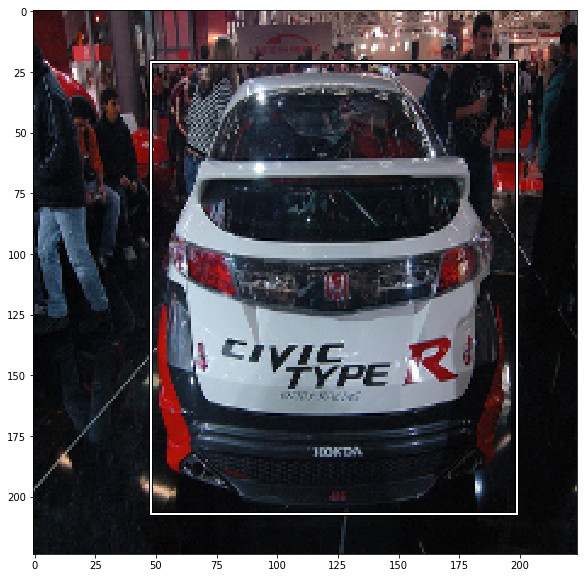

In [4]:
IMAGE_SIZE = 224
data = train_dataset[19]
print(data)
img_path = os.path.join(image_path, data["image"]['file_name'])

ori_img = Image.open(img_path)
img = np.array(ori_img)
height = data["image"]["height"]
width = data["image"]["width"]

x0, y0, x1, y1 = data['annotation']["bbox"]

x_scale = IMAGE_SIZE / width
y_scale = IMAGE_SIZE / height

x0 = int(x0 * x_scale)
y0 = int(y0 * y_scale)
x1 = int(x1 * x_scale)
y1 = int(y1 * y_scale)
bbox = [x0, y0, x1, y1]
print(bbox)

img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = img.astype("float") / 255.0
print(img.shape)
# print(img)

ax = show_img(img)
draw_rect(ax, bbox)

ori_img.close()

### Image Augmentation ###
As we know image augmentation is usually apply to improve model robustness and help to generalise better. This is also a good way to increase our dataset size if our dataset is relatively small. But do take note that augment image too agressive will cost model not able to learn. We should always augment image in ways that could happen in real production usage. Eg. Lightings (bright or dark), orientation (horizontal or vertial flip), colors (Orange or blue light filters), etc. Take it as these augmentation is to prepare our model to work on foreseeable problems.<br><br>
**NOTE:** <br>
Since we are building a model detect single object with bounding box, augmentation techniques like rotation or scaling will affect bounding box position. We need to apply the same augmentation to the bounding box too. It is not discuss here refer to augmentation notebook for further details.

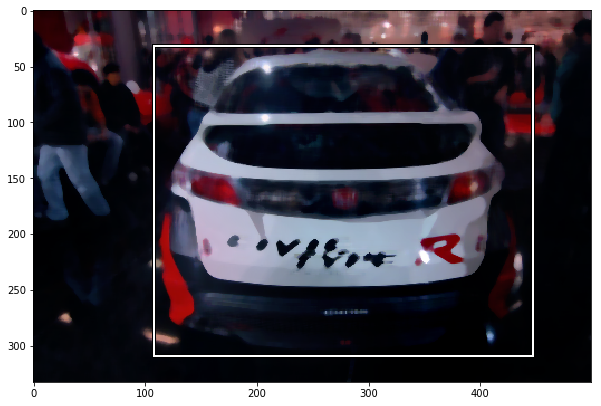

In [5]:
import imgaug as ia
from imgaug import augmenters as iaa
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data = train_dataset[19]
img_path = os.path.join(image_path, data["image"]['file_name'])

ori_img = Image.open(img_path)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential(
    [
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 0.5), n_segments=(100, 300))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
#                 sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
#                 sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
#                 sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

bbox = data['annotation']["bbox"]
img = seq.augment_image(np.array(ori_img))

ax = show_img(img)
draw_rect(ax, bbox)

### Building custom model ###
We will be building a custom model to draw bounding box around the largest classified item in our image. We will create a custom validation which calculate the IoU between the actual and prediction bounding box. Our model is a simple model using layers of dense and dropout. We also use GlobalAveragePooling2D instead of flatten layer because the primal provides better extraction of features than flatten on images. <br>
**Result:**<br>
Model produce the result of 0.52 AP not the best but in research papers this is usually the baseline.

In [6]:
# determin percentage of MobileNetV2 will be used **Check later
ALPHA = 1.3

# training parameters
BATCH_SIZE = 64
# 96, 128, 160, 192, 224
IMAGE_SIZE = 224
EPOCHS = 200
PATIENCE = 50
MULTI_PROCESSING = True
THREADS = 4

class DataGenerator(Sequence):

    def __init__(self, dataset, is_augmentated=False):
        self.is_augmentated = is_augmentated
        self.paths = []
        self.coords = np.zeros((len(dataset), 4))
        
        for idx, data in enumerate(dataset):
            img_path = os.path.join(image_path, data["image"]['file_name'])
            self.paths.append(img_path)
            
            width = data["image"]["width"]
            height = data["image"]["height"]
        
            x_scale = IMAGE_SIZE / width
            y_scale = IMAGE_SIZE / height
            x0, y0, x1, y1 = data['annotation']["bbox"]
                        
            self.coords[idx, 0] = int(x0 * x_scale)
            self.coords[idx, 1] = int(y0 * y_scale)
            self.coords[idx, 2] = int(x1 * x_scale)
            self.coords[idx, 3] = int(y1 * y_scale)
            
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    def __getitem__(self, idx):
        # print("Range: {} {} ".format(idx * BATCH_SIZE, (idx + 1) * BATCH_SIZE))
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        
        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            ori_img = Image.open(f)
            img = ori_img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')            
            if(self.is_augmentated):
                img = seq.augment_image(np.array(img))
            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            ori_img.close()
        return batch_images, batch_coords

    
class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator
    
    def on_epoch_end(self, epoch, logs):
        mse = 0
        intersections = 0
        unions = 0
        
        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i]
            pred = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]
            
            pred = np.maximum(pred, 0)
            
            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)
            
            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = np.maximum(area_gt + area_pred - intersection, 0)

            intersections += np.sum(intersection * (union > 0))
            unions += np.sum(union)
            
        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        mse = np.round(mse, 4)
        logs["val_mse"] = mse 
        print(" - val_iou: {} - val_mse: {}".format(iou, mse))

        
def create_model(trainable=False):
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)
    
    # freeze layers
    for layer in model.layers[:-5]:
        layer.trainable = trainable
    
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4)(x)    
    
    return Model(inputs=model.input, outputs=x)

In [13]:
model = create_model()

WEIGHTS_FILE = "model-0.52.h5"
model.load_weights(WEIGHTS_FILE)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 40) 1080        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 40) 160         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [14]:
train_datagen = DataGenerator(train_dataset, is_augmentated=True)
val_datagen = Validation(generator=DataGenerator(val_dataset, is_augmentated=True))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[])

checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True, 
                             save_weights_only=True, mode="max", period=1)
earlystop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

history = model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_datagen, checkpoint, reduce_lr, earlystop],
                    workers=THREADS,
                    use_multiprocessing=False,
                    shuffle=True,
                    verbose=1)

Epoch 1/200
62/63 [============================>.] - ETA: 0s - loss: 1889.2629 - val_iou: 0.4197 - val_mse: 184.1203

Epoch 00001: val_iou improved from -inf to 0.41970, saving model to model-0.42.h5
63/63 [==============================] - 91s 1s/step - loss: 1890.8324
Epoch 2/200
62/63 [============================>.] - ETA: 0s - loss: 1808.7925 - val_iou: 0.4537 - val_mse: 170.5951

Epoch 00002: val_iou improved from 0.41970 to 0.45370, saving model to model-0.45.h5
63/63 [==============================] - 71s 1s/step - loss: 1811.7765
Epoch 3/200
62/63 [============================>.] - ETA: 0s - loss: 1763.7361 - val_iou: 0.4247 - val_mse: 179.0987

Epoch 00003: val_iou did not improve from 0.45370
63/63 [==============================] - 71s 1s/step - loss: 1758.2077
Epoch 4/200
62/63 [============================>.] - ETA: 0s - loss: 1759.6601 - val_iou: 0.4132 - val_mse: 186.2631

Epoch 00004: val_iou did not improve from 0.45370
63/63 [==============================] - 71s 1s/

Epoch 67/200
62/63 [============================>.] - ETA: 0s - loss: 1485.5282 - val_iou: 0.4658 - val_mse: 159.8877

Epoch 00067: val_iou did not improve from 0.47110
63/63 [==============================] - 71s 1s/step - loss: 1489.3125
Epoch 68/200
62/63 [============================>.] - ETA: 0s - loss: 1415.7802 - val_iou: 0.4583 - val_mse: 161.6235

Epoch 00068: val_iou did not improve from 0.47110
63/63 [==============================] - 73s 1s/step - loss: 1416.6277
Epoch 69/200
62/63 [============================>.] - ETA: 0s - loss: 1476.2612 - val_iou: 0.454 - val_mse: 165.1464

Epoch 00069: val_iou did not improve from 0.47110
63/63 [==============================] - 71s 1s/step - loss: 1476.9482
Epoch 70/200
62/63 [============================>.] - ETA: 0s - loss: 1468.6585 - val_iou: 0.4619 - val_mse: 161.7597

Epoch 00070: val_iou did not improve from 0.47110
63/63 [==============================] - 72s 1s/step - loss: 1466.9136
Epoch 71/200
62/63 [=====================

### Testing our model ##
We test our model by loading our trained weights. It does fairly, I expected more but its only at baseline. Hopefully we could improve this.

In [7]:
import glob
import cv2

# Testing model 
WEIGHTS_FILE = "model-0.52.h5"

model = create_model()
model.load_weights(WEIGHTS_FILE)

In [16]:
for filename in glob.glob("dataset/JPEGImages/*jpg"):
    unscaled = cv2.imread(filename)
    image_height, image_width, _ = unscaled.shape
    print(unscaled.shape)
    
    image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
    
    region = model.predict(x=np.array([feat_scaled]))[0]
    
    x0 = int(region[0] * image_width / IMAGE_SIZE)
    y0 = int(region[1] * image_height / IMAGE_SIZE)
    
    x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
    y1= int((region[1] + region[3]) * image_height / IMAGE_SIZE)
    print((x0, y0), (x1, y1))
    
    cv2.rectangle(unscaled, (x0, y0), (x1, y1), (0, 0, 255), 1)
    cv2.imshow("image", unscaled)
    
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break    
    cv2.destroyAllWindows()

(375, 500, 3)
(228, 248) (396, 345)
(333, 500, 3)
(40, 57) (454, 318)
(375, 500, 3)
(143, 126) (361, 307)
(333, 500, 3)
(150, 77) (395, 295)
(500, 334, 3)
(56, 49) (297, 498)
(364, 480, 3)
(24, 105) (401, 315)
(375, 500, 3)
(26, 126) (409, 318)
(500, 375, 3)
(20, 125) (315, 433)


### Use a skip-net architecture similar to U-Net ###
** Can we improve this?** <br>
What if we provide a more complex model will it able to learn better than the previous one. I came across this network architecture call U-Net which is commonly use in medical imagery. No harm trying right?
<img src="https://camo.githubusercontent.com/06a44a1ce41528848269567f11cee184c32c9fee/68747470733a2f2f6c61727337362e6769746875622e696f2f6173736574732f696d616765732f6172636869746563747572652e706e67", width=700, height=400>


In [10]:
# block_5_add (Add)               (None, 28, 28, 40)   0           block_4_add[0][0]                
#                                                                  block_5_project_BN[0][0]
# block_12_add (Add)              (None, 14, 14, 128)  0           block_11_add[0][0]               
#                                                                  block_12_project_BN[0][0]
# block_15_add (Add)              (None, 7, 7, 208)    0           block_14_add[0][0]               
#                                                                  block_15_project_BN[0][0]        

def create_skip_net_model(trainable=False):
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer("block_5_add").output
    block2 = model.get_layer("block_12_add").output
    block3 = model.get_layer("block_15_add").output
    
    blocks = [block2, block1]
    x = block3
    
    for block in blocks:
        x = UpSampling2D()(x)
        
        x = Conv2D(256, kernel_size=3, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Concatenate()([x, block])
        
        x = Conv2D(256, kernel_size=3, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = GlobalAveragePooling2D()(x)
    x = Dense(4)(x) 
    
    return Model(inputs=model.input, outputs=x)
    
model = create_skip_net_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 40) 1080        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 40) 160         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [9]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

Using TensorFlow backend.


In [11]:
train_datagen = DataGenerator(train_dataset, is_augmentated=True)
val_datagen = Validation(generator=DataGenerator(val_dataset, is_augmentated=True))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[])

checkpoint = ModelCheckpoint("model_skipnet-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True, 
                             save_weights_only=True, mode="max", period=1)
earlystop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

history = model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_datagen, checkpoint, reduce_lr, earlystop],
                    workers=THREADS,
                    use_multiprocessing=False,
                    shuffle=True,
                    verbose=1)

Epoch 1/200
62/63 [============================>.] - ETA: 0s - loss: 11578.2549 - val_iou: 0.0024 - val_mse: 419.9903

Epoch 00001: val_iou improved from -inf to 0.00240, saving model to model_skipnet-0.00.h5
63/63 [==============================] - 89s 1s/step - loss: 11551.5858
Epoch 2/200
62/63 [============================>.] - ETA: 0s - loss: 9813.9128 - val_iou: 0.0121 - val_mse: 389.4206

Epoch 00002: val_iou improved from 0.00240 to 0.01210, saving model to model_skipnet-0.01.h5
63/63 [==============================] - 72s 1s/step - loss: 9785.4075
Epoch 3/200
62/63 [============================>.] - ETA: 0s - loss: 7848.7253 - val_iou: 0.062 - val_mse: 317.1105

Epoch 00003: val_iou improved from 0.01210 to 0.06200, saving model to model_skipnet-0.06.h5
63/63 [==============================] - 78s 1s/step - loss: 7840.9443
Epoch 4/200
62/63 [============================>.] - ETA: 0s - loss: 5973.9163 - val_iou: 0.1032 - val_mse: 288.3188

Epoch 00004: val_iou improved from 0.0

Epoch 33/200
62/63 [============================>.] - ETA: 0s - loss: 747.5445 - val_iou: 0.4884 - val_mse: 157.3812

Epoch 00033: val_iou did not improve from 0.51230
63/63 [==============================] - 72s 1s/step - loss: 749.8145
Epoch 34/200
62/63 [============================>.] - ETA: 0s - loss: 760.2556 - val_iou: 0.4927 - val_mse: 154.7932

Epoch 00034: val_iou did not improve from 0.51230
63/63 [==============================] - 69s 1s/step - loss: 757.7432
Epoch 35/200
62/63 [============================>.] - ETA: 0s - loss: 716.9878 - val_iou: 0.4909 - val_mse: 156.0566

Epoch 00035: val_iou did not improve from 0.51230
63/63 [==============================] - 72s 1s/step - loss: 717.0824
Epoch 36/200
62/63 [============================>.] - ETA: 0s - loss: 714.7869 - val_iou: 0.4844 - val_mse: 158.4206

Epoch 00036: val_iou did not improve from 0.51230
63/63 [==============================] - 71s 1s/step - loss: 717.0224
Epoch 37/200
62/63 [============================

Epoch 67/200
62/63 [============================>.] - ETA: 0s - loss: 656.8321 - val_iou: 0.4992 - val_mse: 154.4871

Epoch 00067: val_iou did not improve from 0.51230
63/63 [==============================] - 71s 1s/step - loss: 657.7125
Epoch 68/200
62/63 [============================>.] - ETA: 0s - loss: 665.7559 - val_iou: 0.5014 - val_mse: 153.4734

Epoch 00068: val_iou did not improve from 0.51230
63/63 [==============================] - 73s 1s/step - loss: 665.2247
Epoch 69/200
62/63 [============================>.] - ETA: 0s - loss: 648.8737 - val_iou: 0.5045 - val_mse: 154.2207

Epoch 00069: val_iou did not improve from 0.51230
63/63 [==============================] - 72s 1s/step - loss: 649.8992
Epoch 70/200
62/63 [============================>.] - ETA: 0s - loss: 667.2701 - val_iou: 0.4987 - val_mse: 156.237

Epoch 00070: val_iou did not improve from 0.51230
63/63 [==============================] - 71s 1s/step - loss: 666.6546
Epoch 71/200
62/63 [============================>

Darn no improvement at all, complex model don't always perform better. We need a way to see what the model have learn. Then probably we could find a way to improve its performance. <br>
Still stuck at 0.52 AP